<a href="https://colab.research.google.com/github/ericdnbn/nn_image_classifier_pneumonia/blob/main/Eric%E2%80%93nn_classifier_colab_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, shutil
import time
import matplotlib.pyplot as plt
import scipy
import numpy as np
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
train_dir = 'chest_xray/train'
val_dir = 'chest_xray/val'
test_dir = 'chest_xray/test/' 

In [3]:
!find . -name ".DS_Store" -delete

In [4]:
train_normal_dir = os.path.join(train_dir, 'NORMAL')
train_pneu_dir = os.path.join(train_dir, 'PNEUMONIA')

test_normal_dir = os.path.join(test_dir, 'NORMAL')
test_pneu_dir = os.path.join(test_dir, 'PNEUMONIA')

val_normal_dir = os.path.join(val_dir, 'NORMAL')
val_pneu_dir = os.path.join(val_dir, 'PNEUMONIA')

In [5]:
train_normal_dir

'chest_xray/train/NORMAL'

In [6]:
len(os.listdir(train_normal_dir))

1242

In [7]:
# get all the data in the directory split/train (542 images), and reshape them
arg_dict = {'target_size':(100, 100), 
            'color_mode':'grayscale', 
            'batch_size':50}

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)


train_generator = train_datagen.flow_from_directory(train_dir, **arg_dict, subset='training')


# get all the data in the directory split/test (180 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir, **arg_dict) 


# get all the data in the directory split/validation (200 images), and reshape them
val_generator = train_datagen.flow_from_directory(train_dir, **arg_dict, subset='validation')


Found 4187 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


In [8]:
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [9]:
train_images[0]

array([[[0.18431373],
        [0.1764706 ],
        [0.20392159],
        ...,
        [0.1764706 ],
        [0.16862746],
        [0.16862746]],

       [[0.15686275],
        [0.18823531],
        [0.21960786],
        ...,
        [0.19607845],
        [0.18431373],
        [0.1764706 ]],

       [[0.17254902],
        [0.20392159],
        [0.24313727],
        ...,
        [0.21176472],
        [0.20784315],
        [0.18823531]],

       ...,

       [[0.38431376],
        [0.4666667 ],
        [0.4784314 ],
        ...,
        [0.04313726],
        [0.0509804 ],
        [0.0509804 ]],

       [[0.38823533],
        [0.43921572],
        [0.48627454],
        ...,
        [0.04313726],
        [0.0509804 ],
        [0.0509804 ]],

       [[0.3803922 ],
        [0.43529415],
        [0.48627454],
        ...,
        [0.04705883],
        [0.0509804 ],
        [0.05490196]]], dtype=float32)

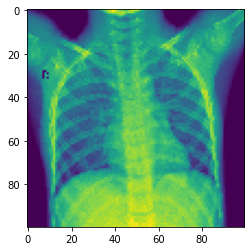

In [10]:
plt.imshow(train_images[3])

In [11]:
train_images.shape[0]

50

In [12]:
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 50
Number of testing samples: 50
Number of validation samples: 50
train_images shape: (50, 100, 100, 1)
train_labels shape: (50, 2)
test_images shape: (50, 100, 100, 1)
test_labels shape: (50, 2)
val_images shape: (50, 100, 100, 1)
val_labels shape: (50, 2)


In [13]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(50, 10000)
(50, 10000)
(50, 10000)


In [14]:
train_y = np.reshape(train_labels[:,0], (train_images.shape[0],1))
test_y = np.reshape(test_labels[:,0], (test_images.shape[0],1))
val_y = np.reshape(val_labels[:,0], (val_images.shape[0],1))

print(train_y)
print(test_y)
print(val_y)

[[0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]]
[[0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [15]:
# First Simple Model
model = models.Sequential()

In [16]:
model.add(layers.Dense(32, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(1, activation='sigmoid'))

In [17]:
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy', 'Recall'])

In [18]:
history = model.fit(train_img, 
                     train_y,
                     epochs=50,
                     batch_size=10,
                     validation_data=(val_img, val_y))

Epoch 1/50
5/5 [==============================] - 0s 72ms/step - loss: 1.0962 - accuracy: 0.6800 - recall: 0.2857 - val_loss: 0.7454 - val_accuracy: 0.2400 - val_recall: 1.0000
Epoch 2/50
5/5 [==============================] - 0s 21ms/step - loss: 0.7119 - accuracy: 0.2600 - recall: 0.7857 - val_loss: 0.6897 - val_accuracy: 0.8000 - val_recall: 0.4167
Epoch 3/50
5/5 [==============================] - 0s 17ms/step - loss: 0.6897 - accuracy: 0.7200 - recall: 0.0714 - val_loss: 0.6875 - val_accuracy: 0.7800 - val_recall: 0.1667
Epoch 4/50
5/5 [==============================] - 0s 16ms/step - loss: 0.6877 - accuracy: 0.7200 - recall: 0.0000e+00 - val_loss: 0.6839 - val_accuracy: 0.7600 - val_recall: 0.0000e+00
Epoch 5/50
5/5 [==============================] - 0s 14ms/step - loss: 0.6853 - accuracy: 0.7200 - recall: 0.0000e+00 - val_loss: 0.6813 - val_accuracy: 0.7600 - val_recall: 0.0000e+00
Epoch 6/50
5/5 [==============================] - 0s 20ms/step - loss: 0.6826 - accuracy: 0.7400 - 

5/5 [==============================] - 0s 9ms/step - loss: 0.5874 - accuracy: 0.8400 - recall: 0.4286 - val_loss: 0.5974 - val_accuracy: 0.7800 - val_recall: 0.1667
Epoch 46/50
5/5 [==============================] - 0s 20ms/step - loss: 0.5891 - accuracy: 0.8600 - recall: 0.5000 - val_loss: 0.6004 - val_accuracy: 0.7600 - val_recall: 0.0000e+00
Epoch 47/50
5/5 [==============================] - 0s 13ms/step - loss: 0.5914 - accuracy: 0.8200 - recall: 0.3571 - val_loss: 0.5907 - val_accuracy: 0.7800 - val_recall: 0.1667
Epoch 48/50
5/5 [==============================] - 0s 14ms/step - loss: 0.5706 - accuracy: 0.9000 - recall: 0.6429 - val_loss: 0.5900 - val_accuracy: 0.7600 - val_recall: 0.0000e+00
Epoch 49/50
5/5 [==============================] - 0s 13ms/step - loss: 0.5687 - accuracy: 0.8800 - recall: 0.5714 - val_loss: 0.5850 - val_accuracy: 0.7800 - val_recall: 0.1667
Epoch 50/50
5/5 [==============================] - 0s 12ms/step - loss: 0.5822 - accuracy: 0.8800 - recall: 0.6429 

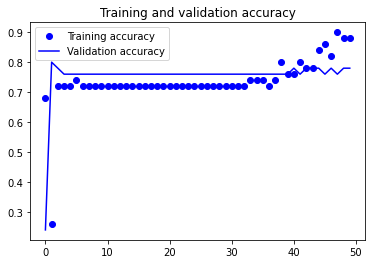

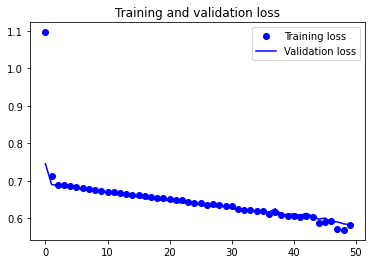

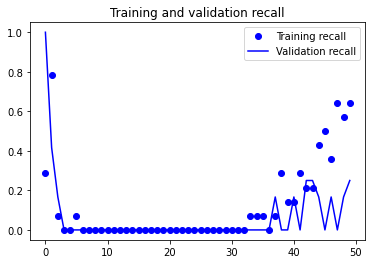

In [19]:

import matplotlib.pyplot as plt
%matplotlib inline 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
recall = history.history['recall']
val_recall = history.history['val_recall']

epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()
plt.plot(epochs, recall, 'bo', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()
plt.show()

In [20]:
results_train = model.evaluate(train_img, train_y)

2/2 [==============================] - 0s 1ms/step - loss: 0.5555 - accuracy: 0.9000 - recall: 0.6429


In [21]:
results_train

[0.5555261373519897, 0.8999999761581421, 0.6428571343421936]

In [22]:
results_test = model.evaluate(test_img, test_y)

2/2 [==============================] - 0s 1ms/step - loss: 0.6106 - accuracy: 0.7200 - recall: 0.2222


In [23]:
results_test

[0.6106202006340027, 0.7200000286102295, 0.2222222238779068]

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [25]:
preds = (model.predict(train_img) > 0.5).astype('int32')

cm = confusion_matrix(train_y, preds)

In [26]:
cm

array([[36,  0],
       [ 5,  9]])

In [27]:
cmd = ConfusionMatrixDisplay(cm, display_labels=['Nomral', 'Pneumonia'])

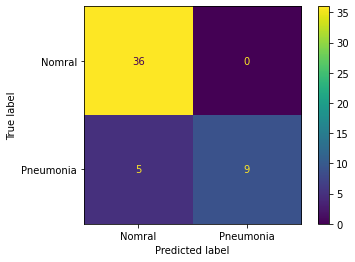

In [28]:
cmd.plot()

In [29]:
from sklearn.utils import class_weight

# Calculate floats/raw class weights
class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_generator.classes), 
                train_generator.classes)

# Convert to dict for .fit(class_weight= ) param
nn_class_weights = {0:class_weights[0],
                    1:class_weights[1]}

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [30]:
def preprocessing_dense_data(train_directory=train_dir,
                             test_directory=test_dir,
                             ts_tuple=(256,256), 
                             color='grayscale', 
                             batch_size=None,
                             process_test=False):

    
    arg_dict = {'target_size':ts_tuple, 
                'color_mode':color, 
                'batch_size':batch_size}

    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
       
    train_generator = train_datagen.flow_from_directory(train_dir, **arg_dict, subset='training') 

    val_generator = train_datagen.flow_from_directory(train_dir, **arg_dict, subset='validation')
    
    
    train_images, train_labels = next(train_generator)
    
    val_images, val_labels = next(val_generator)
    
    
    X_train = train_images.reshape(train_images.shape[0], -1)
    
    X_val = val_images.reshape(val_images.shape[0], -1)
    
    
    y_train = np.reshape(train_labels[:,0], (train_images.shape[0],1))
    
    y_val = np.reshape(val_labels[:,0], (val_images.shape[0],1))
    
    
    return X_train, X_val, y_train, y_val
    
    
    
    
    if process_test:
        
        test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir, **arg_dict, subset='test')
        
        test_images, test_labels = next(test_generator)
        
        X_test = test_images.reshape(test_images.shape[0], -1)
        
        y_test = np.reshape(test_labels[:,0], (test_images.shape[0],1))
        
        return X_test, y_test
    
   
    
    


In [31]:
X_train, X_val, y_train, y_val = preprocessing_dense_data(batch_size=200)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


In [32]:
model2 = models.Sequential()

In [33]:
model2.add(layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model2.add(layers.Dense(16, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

In [34]:
model2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy', 'Recall'])

In [35]:
history2 = model2.fit(X_train, 
                     y_train,
                     epochs=50,
                     batch_size=10,
                     validation_data=(X_val, y_val))

Epoch 1/50
20/20 [==============================] - 1s 32ms/step - loss: 0.6075 - accuracy: 0.7350 - recall: 0.0000e+00 - val_loss: 0.6007 - val_accuracy: 0.6850 - val_recall: 0.0000e+00
Epoch 2/50
20/20 [==============================] - 0s 21ms/step - loss: 0.5633 - accuracy: 0.7350 - recall: 0.0000e+00 - val_loss: 0.5740 - val_accuracy: 0.6850 - val_recall: 0.0000e+00
Epoch 3/50
20/20 [==============================] - 0s 17ms/step - loss: 0.5750 - accuracy: 0.7350 - recall: 0.0000e+00 - val_loss: 0.5793 - val_accuracy: 0.6850 - val_recall: 0.0000e+00
Epoch 4/50
20/20 [==============================] - 0s 18ms/step - loss: 0.5253 - accuracy: 0.7350 - recall: 0.0000e+00 - val_loss: 0.5824 - val_accuracy: 0.6850 - val_recall: 0.0000e+00
Epoch 5/50
20/20 [==============================] - 0s 18ms/step - loss: 0.5313 - accuracy: 0.7350 - recall: 0.0000e+00 - val_loss: 0.6889 - val_accuracy: 0.6850 - val_recall: 0.0000e+00
Epoch 6/50
20/20 [==============================] - 0s 19ms/step 

20/20 [==============================] - 0s 23ms/step - loss: 0.7150 - accuracy: 0.2650 - recall: 1.0000 - val_loss: 0.7049 - val_accuracy: 0.3150 - val_recall: 1.0000
Epoch 47/50
20/20 [==============================] - 0s 17ms/step - loss: 0.7025 - accuracy: 0.2650 - recall: 1.0000 - val_loss: 0.6954 - val_accuracy: 0.3250 - val_recall: 1.0000
Epoch 48/50
20/20 [==============================] - 1s 30ms/step - loss: 0.6910 - accuracy: 0.6050 - recall: 0.3208 - val_loss: 0.6869 - val_accuracy: 0.6850 - val_recall: 0.0000e+00
Epoch 49/50
20/20 [==============================] - 0s 18ms/step - loss: 0.6807 - accuracy: 0.7350 - recall: 0.0000e+00 - val_loss: 0.6794 - val_accuracy: 0.6850 - val_recall: 0.0000e+00
Epoch 50/50
20/20 [==============================] - 0s 21ms/step - loss: 0.6714 - accuracy: 0.7350 - recall: 0.0000e+00 - val_loss: 0.6726 - val_accuracy: 0.6850 - val_recall: 0.0000e+00


In [36]:
def visualize_nn(history, model, X, y_true):
    acc = history.history['accuracy']
    mean_acc = np.mean(history.history['accuracy'])
    val_acc = history.history['val_accuracy']
    mean_val_acc = np.mean(history.history['val_accuracy'])
    loss = history.history['loss']
    mean_loss = np.mean(history.history['loss'])
    val_loss = history.history['val_loss']
    mean_val_loss = np.mean(history.history['val_loss'])
    recall = history.history['recall']
    mean_recall = np.mean(history.history['recall'])
    val_recall = history.history['val_recall']
    mean_val_recall = np.mean(history.history['val_recall'])

    epochs = range(len(acc))
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.figure()
    plt.plot(epochs, recall, 'bo', label='Training recall')
    plt.plot(epochs, val_recall, 'b', label='Validation recall')
    plt.title('Training and validation recall')
    plt.legend()
    plt.show()
    
    
    print(f'Mean Training Accuracy: {mean_acc}')
    print(f'Mean Validation Accuracy: {mean_val_acc}')
    
    print(f'Mean Training Loss: {mean_loss}')
    print(f'Mean Validation Loss: {mean_val_loss}')
    
    print(f'Mean Training Recall: {mean_recall}')
    print(f'Mean Validation Recall: {mean_val_recall}')
    
    training_eval = model.evaluate(X_train, y_train)
    validation_eval = model.evaluate(X_val, y_val)
                                   
    print(f'Training Evaluation: {training_eval}')
    print(f'Validation Evaluation: {training_eval}')
    
    
    
    preds = (model.predict(X) > 0.5).astype('int32')

    cm = confusion_matrix(y_true, preds)
    
    cmd = ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Pneumonia'])
    
    cmd.plot();

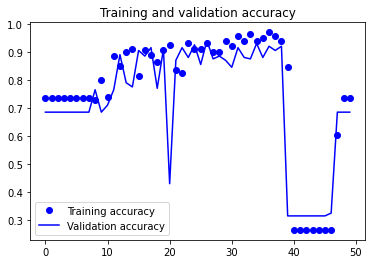

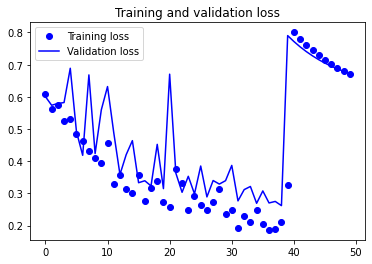

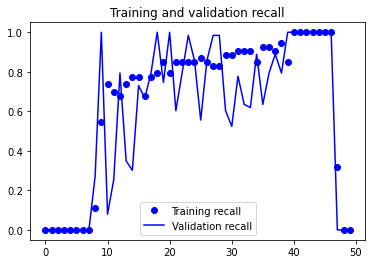

Mean Training Accuracy: 0.7678000009059907
Mean Validation Accuracy: 0.7269000005722046
Mean Training Loss: 0.4135673281550407
Mean Validation Loss: 0.48020294547080994
Mean Training Recall: 0.6584905678033829
Mean Validation Recall: 0.5952381028234959
7/7 [==============================] - 0s 7ms/step - loss: 0.6726 - accuracy: 0.6850 - recall: 0.0000e+00
Training Evaluation: [0.6667433381080627, 0.7350000143051147, 0.0]
Validation Evaluation: [0.6667433381080627, 0.7350000143051147, 0.0]


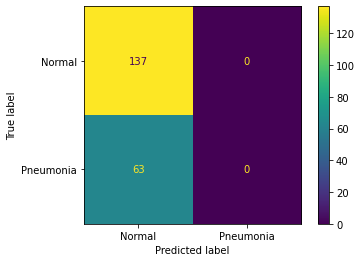

In [37]:
visualize_nn(history2, model2, X_val, y_val)

In [38]:
def nn_model(dense_list, 
             train_directory=train_dir,
             test_directory=test_dir,
             val_directory=val_dir,
             ts_tuple=(256,256), 
             color='grayscale',
             batch_size=1000,
             process_test=False,
             input_activation='relu',
             layer_activation='relu',
             output_activation='sigmoid',
             l2_rate=0.01,
             optimizer='sgd',
             loss='binary_crossentropy',
             metrics=['accuracy', 'Recall'],
             epochs=50,
             bs=10):
    
    if not process_test:
        X_train, X_val, y_train, y_val = preprocessing_dense_data(batch_size=batch_size)
    
    else:
        X_train, X_test, X_val, y_train, y_test, y_val = preprocessing_dense_data(batch_size=batch_size)
    
    nn_model = models.Sequential()
    
    
    nn_model.add(layers.Dense(64, activation=input_activation, input_shape=(X_train.shape[1],)))
    
    for i, val in enumerate(dense_list):
        nn_model.add(layers.Dense(int(dense_list[i]), 
                                  activation=layer_activation,
                                  kernel_regularizer=l2(l2=l2_rate)))
        
        
    nn_model.add(layers.Dense(1, activation=output_activation))
        
    nn_model.compile(optimizer=optimizer,
                     loss=loss,
                     metrics=metrics)
    
    
    hist = nn_model.fit(X_train, y_train, epochs=epochs, batch_size=bs, validation_data=(X_val, y_val))
    
    visualize_nn(history, nn_model, X_val, y_val)
    

In [ ]:
nn_model([32,16],batch_size=1000)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


In [ ]:
nn_model([32,16,8],batch_size=1000)

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))